# Exploring CMH Parking Violations

## Imports

* pandas

In [10]:
#%matplotlib inline
#import numpy as np

import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt

### Loading data

[Columbus City Parking Violations and Ticket Status 2013-2018 -- COLUEXTRACT](https://discovery.smartcolumbusos.com/dataset/conduent/160c98a1_ad56_4658_8553_5ee8e7d0d953) - Smart Columbus

This dataset covers the parking violations identified by Parking Enforcement Officer (PEO) and the tickets issued for those violations. Also, the data identifies the status of the ticket (e.g., paid, dismissed, etc.,) This dataset covers years 2013 through 2018.

In [11]:
parking = pd.read_csv("../data/raw/160c98a1-ad56-4658-8553-5ee8e7d0d953.csv.gz", compression = 'gzip', low_memory = False)

In [151]:
#pd.set_option('display.max_columns', None)
#parking.info()

In [153]:
dictionary = pd.read_json("https://data.smartcolumbusos.com/api/v1/dataset/160c98a1-ad56-4658-8553-5ee8e7d0d953/dictionary")
pd.set_option('display.max_colwidth', -1)
dictionary

,type,name,description
0,integer,ENTITY,Unique system-generated number to identify license plate-based accounts
1,integer,TERMDT,"If a license plate was on a fleet and terminated, this would record the date on which the plate was terminated from the fleet. Julian date format."
2,integer,MULTNO,"If a license plate was on a fleet, that fleet is identified with this number"
3,string,ENT DUE,Total amount due on the entity
4,string,ENT OVP,Overpaid amount on the entity
5,integer,CONF DT,Date on which the BMV/Registry returned registered owner name and address information
6,integer,HOLD CT,Total number of tickets on the entity on registration hold
7,integer,LAST SEIZ,Date on which the vehicle was last seized
8,string,SEIZ STAT,Indicates if the vehicle is currently seized
9,integer,SEIZ DT,Date on which the vehicle was released on the last seizure record


In [14]:
G = ox.graph_from_place('Columbus, Ohio, USA', network_type='drive')

In [15]:
type(G)
# can we cache this? it takes forever to download..

networkx.classes.multidigraph.MultiDiGraph

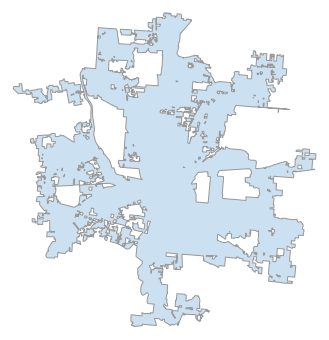

In [155]:
cmh = ox.gdf_from_place('Columbus, Ohio')
Gs = ox.plot_shape(ox.project_gdf(cmh))

cmh_boundaries = ox.project_gdf(cmh)
cmh_n = cmh_boundaries.bbox_north[0]
cmh_s = cmh_boundaries.bbox_south[0]
cmh_e = cmh_boundaries.bbox_east[0]
cmh_w = cmh_boundaries.bbox_west[0]

In [18]:
parking['lat_float'] = parking['lat'] / 1000000
parking['long_float'] = parking['long'] / 1000000 * -1

In [19]:
meters = pd.read_csv("../data/raw/d9b11b8f-67f3-48c4-8831-0f22d93166ce")
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone            5490 non-null object
Area            5490 non-null object
Sub Area        5490 non-null object
Meter Number    5490 non-null object
ConfigId        5490 non-null int64
Lat             5490 non-null float64
Long            5490 non-null float64
Active          5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [157]:
#meters[meters['meter number'] == 'EN529']

meters = meters.rename(columns = {'Meter Number': 'Meter'})
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone        5490 non-null object
Area        5490 non-null object
Sub Area    5490 non-null object
Meter       5490 non-null object
ConfigId    5490 non-null int64
Lat         5490 non-null float64
Long        5490 non-null float64
Active      5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [159]:
parking_loc = parking[['meter', 'lat_float', 'long_float', 'location']]
parking_loc = parking_loc.rename(columns = { 'meter': 'Meter'})

meters_loc = meters[['Meter', 'Lat', 'Long']]

parking_x_meters = parking_loc.merge(meters_loc, how = 'left', on = 'Meter')

pxm = parking_x_meters.copy()

In [160]:
#print (cmh_n, cmh_s, cmh_e, cmh_w)
fudge = 0.2
pxm['lat_combined'] = \
    pxm.apply(lambda p: p['Lat'] if (p['Lat'] >  cmh_s - fudge) & (p['Lat'] < cmh_n + fudge) \
                                    else p['lat_float'], axis=1)

pxm['long_combined'] = \
    pxm.apply(lambda p: p['Long'] if (p['Long'] >  cmh_w - fudge) & (p['Long'] < cmh_e + fudge)  \
                                    else  p['long_float'], axis=1)

In [166]:
pxm_na = pxm[['lat_combined', 'lat_float', 'Lat', 'long_combined', 'long_float', 'Long', 'location', 'Meter']]
pxm_na[['lat_combined', 'long_combined', 'location', 'Meter']].sample(200)

,lat_combined,long_combined,location,Meter
728012,39.961176,-82.998794,6TH ST N,NS111
731604,39.995239,-83.007617,ELEVENTH AVE W,UW172
576622,0.000000,-0.000000,68 MAYNARD AVE W,NaN
7399,0.000000,-0.000000,24 3RD AVE E,NaN
730734,0.000000,-0.000000,F/O 5024 ALMONT DR,NaN
192271,39.979735,-83.003940,HIGH ST N,K676
718281,39.984068,-83.005656,3RD AVE W,K268
217555,0.000000,-0.000000,1746 14TH AVE E,NaN
515020,0.000000,-0.000000,A\F 1369 FORSYTHE AVE,NaN
163788,39.996857,-83.007008,12TH AVE E,UE154


In [168]:
pxm_have_location = pxm_na[(pxm_na['lat_combined'] > cmh_s - fudge) & (pxm_na['long_combined'] < cmh_e + fudge)]

In [133]:
# f, (ax1) = plt.subplots(1, 1, False, figsize=(15,15))
# ax1.scatter(pxm_have_location['lat_combined'], pxm_have_location['long_combined'], alpha = 0.5, c='red')
# plt.xlabel('lat')
# plt.ylabel('long')
# plt.title('Lat/Long of parking violations')


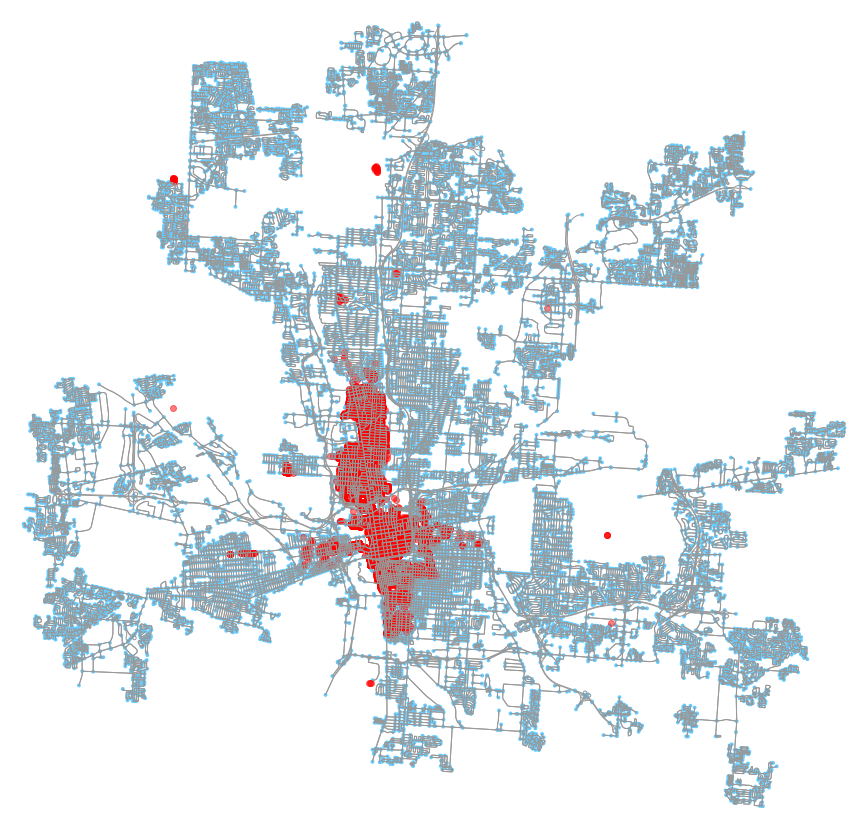

In [169]:

fig, ax = ox.plot_graph(G, fig_height=15, show=False, close=False)
ax.scatter(pxm_have_location['long_combined'], pxm_have_location['lat_combined'], alpha=0.5, c='red')